In [1]:
import os

import matplotlib.pyplot as plt
import torch
import pyro
import copy 

import torch


import pandas as pd
from torch.utils.data import DataLoader

from chirho.indexed.ops import IndexSet, gather, indices_of
import seaborn as sns


import pyro
from pyro.infer import Predictive
import pyro.distributions as dist

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from cities.modeling.simple_linear import SimpleLinear
from cities.modeling.zoning_models.units_causal_model import UnitsCausalModel
from cities.modeling.svi_inference import run_svi_inference
from cities.utils.data_loader import select_from_data


from pyro.infer.autoguide import AutoDiagonalNormal

from cities.utils.data_loader import ZoningDataset
from cities.modeling.evaluation import prep_data_for_test, recode_categorical, test_performance

from cities.modeling.simple_linear import SimpleLinear
from cities.modeling.svi_inference import run_svi_inference
from pyro.infer import Predictive
from chirho.robust.handlers.predictive import PredictiveModel
from chirho.interventional.handlers import do



smoke_test = "CI" in os.environ
n = 20 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000
n_steps = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [28]:
class ToyModel(pyro.nn.PyroModule):

    def __init__(self):
        super().__init__()

    def forward(self):
        with pyro.plate("data", size = 5, dim = -1):
            x = pyro.sample("x", dist.Normal(0, 1))
            y = pyro.sample("y", dist.Normal(0,1))
            z = pyro.sample("z", dist.Normal(x+y,1))
            v = pyro.deterministic("xy", x-y, event_dim=0)
        return z
    
toy_model = ToyModel()
toy_model()

predictive = PredictiveModel(toy_model)

with MultiWorldCounterfactual(first_available_dim=-3) as mwc:
    with do(actions = {"x": torch.tensor(2.)}):
        with do(actions = {"y": torch.tensor(3.)}):
            with pyro.poutine.trace() as tr:
                with pyro.plate("samples", size = 10, dim = -2):
                    out = predictive()

# with MultiWorldCounterfactual():
#     with do(actions = {"x": torch.tensor(2.)}):
#         with pyro.poutine.trace() as tr:
#             with pyro.plate("samples", size = 10, dim = -2):
#                 out = predictive()

# print(out.shape)

print("x", tr.trace.nodes['x']['value'].shape)
print("y", tr.trace.nodes['y']['value'].shape)
print(tr.trace.nodes['z']['value'].shape)

value = tr.trace.nodes['z']['value']

with mwc:
    print(indices_of(value))
    z_unintervened = gather(value, 
                            IndexSet(**{"x": {0}, "y": {0}}),
             event_dim=0,)


z_unintervened.shape
#print(tr.trace.nodes['x']['value'])

#print(tr.trace.nodes['z']['value'].shape)

#print(tr.trace.nodes['x']['value'])
#print(tr.trace.nodes['z']['value'].shape)

x torch.Size([2, 10, 5])
y torch.Size([2, 1, 10, 5])
torch.Size([2, 2, 10, 5])
IndexSet({'x': {0, 1}, 'y': {0, 1}})


torch.Size([1, 1, 10, 5])

In [3]:
zoning_data_path = os.path.join(root, "data/minneapolis/processed/zoning_dataset.pt")

zoning_dataset_read = torch.load(zoning_data_path)

zoning_loader = DataLoader(
    zoning_dataset_read, batch_size=len(zoning_dataset_read), shuffle=True
)

data = next(iter(zoning_loader))

print(data['continuous'].keys())
print(data['categorical'].keys())

kwargs = {  
    "categorical": ["year", "month", "zone_id", "neighborhood_id", "ward_id", 
                    "past_reform"],
    "continuous": {'limit_con', 'parcel_area'},
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)
print(subset.keys())

print(zoning_dataset_read.categorical_levels.keys())



dict_keys(['parcel_area', 'car_parking', 'housing_units', 'limit_con', 'parcel_area_original', 'car_parking_original', 'housing_units_original'])
dict_keys(['parcel_id', 'neighborhood_id', 'ward_id', 'zone_id', 'limit_id', 'past_reform', 'year', 'month', 'day'])
dict_keys(['outcome', 'categorical', 'continuous'])
dict_keys(['parcel_id', 'neighborhood_id', 'ward_id', 'zone_id', 'limit_id', 'past_reform', 'year', 'month', 'day'])


In [4]:
units_model = UnitsCausalModel(**subset, categorical_levels=zoning_dataset_read.categorical_levels)

with pyro.poutine.trace() as tr:
    units_model(**subset)

print(tr.trace.nodes.keys())

#tr.trace.nodes['year']['value']

#tr.trace.nodes['weights_categorical_year_housing_units']['value']

odict_keys(['data', 'year', 'month', 'zone_id', 'neighborhood_id', 'ward_id', 'past_reform', 'past_reform_by_zone', 'sigma_parcel_area', 'weights_categorical_zone_id_parcel_area', 'weights_categorical_neighborhood_id_parcel_area', 'mean_outcome_prediction_parcel_area', 'parcel_area', 'sigma_limit_con', 'weights_categorical_past_reform_by_zone_limit_con', 'mean_outcome_prediction_limit_con', 'limit_con', 'sigma_housing_units', 'bias_continuous_limit_con_housing_units', 'weight_continuous_limit_con_housing_units_', 'bias_continuous_parcel_area_housing_units', 'weight_continuous_parcel_area_housing_units_', 'weights_categorical_year_housing_units', 'weights_categorical_month_housing_units', 'weights_categorical_zone_id_housing_units', 'weights_categorical_neighborhood_id_housing_units', 'weights_categorical_ward_id_housing_units', 'mean_outcome_prediction_housing_units', 'housing_units'])


[iteration 0001] loss: 5773.4771
[iteration 0050] loss: 5040.0884
[iteration 0100] loss: 4680.7812


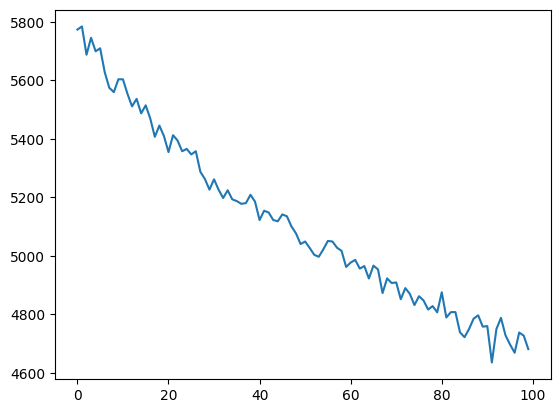

In [5]:
pyro.clear_param_store()
guide = run_svi_inference(units_model, n_steps=100, lr = 0.03,
                           vi_family= AutoDiagonalNormal, **subset)

/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


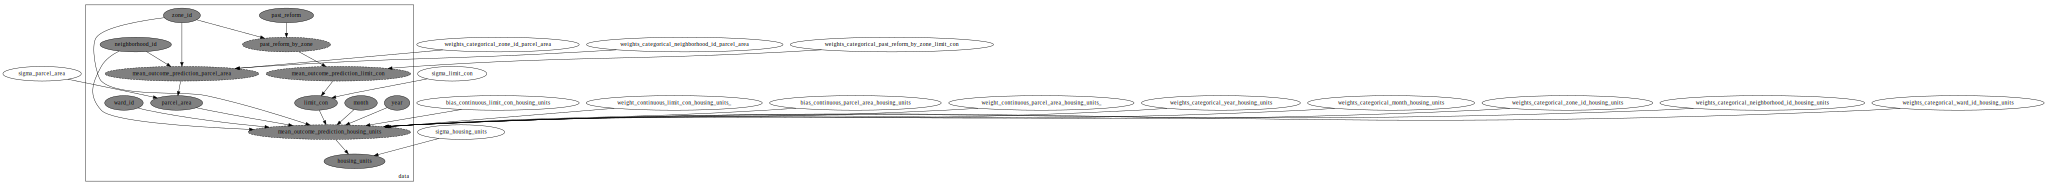

In [6]:
pyro.render_model(lambda:units_model(**subset),
                   filename="units_causal_model.png",
                     render_deterministic=True)

In [7]:
# n = 302
# exp1 = torch.tensor([1.]).expand(n) 
with MultiWorldCounterfactual() as mwc:
    with do(actions = {'limit_con': torch.tensor(1.)}):
        with pyro.poutine.trace() as tr_do:
            units_model(**subset)

print(tr_do.trace.nodes['limit_con']['value'].shape)

#print(tr_do.trace.nodes['housing_units']['value'].shape)
#print(tr_do.trace.nodes['housing_units_a']['value'].shape)# #print(tr_do.trace.nodes['housing_units']['value'])
#print(tr_do.trace.nodes['housing_units_b']['value'].shape)# #print(tr_do.trace.nodes['housing_units']['value'])


torch.Size([2, 1, 1, 1, 302])


In [8]:
with MultiWorldCounterfactual() as mwc:
    with do(actions =  {'limit_con': torch.tensor([1.])}):
        with pyro.poutine.trace() as mwc_tr_do:
            units_model(**subset)

print(tr_do.trace.nodes['limit_con']['value'].shape)
#print(tr_do.trace.nodes['housing_units']['value'])
#with mwc:
#print(mwc_tr_do.trace.nodes['housing_units']['value'].shape)


torch.Size([2, 1, 1, 1, 302])


[iteration 0001] loss: 3547.6528
[iteration 0050] loss: 3347.8660
[iteration 0100] loss: 3186.5144
[iteration 0150] loss: 3067.5647
[iteration 0200] loss: 3027.4670
[iteration 0250] loss: 2934.8125
[iteration 0300] loss: 2842.2429
[iteration 0350] loss: 2773.0923
[iteration 0400] loss: 2743.8826
[iteration 0450] loss: 2641.1973
[iteration 0500] loss: 2630.5432
[iteration 0550] loss: 2747.7786
[iteration 0600] loss: 2584.6565
[iteration 0650] loss: 2539.2366
[iteration 0700] loss: 2551.2366
[iteration 0750] loss: 2611.1802
[iteration 0800] loss: 2515.1997
[iteration 0850] loss: 2422.5466
[iteration 0900] loss: 2387.9246
[iteration 0950] loss: 2403.8809
[iteration 1000] loss: 2455.9656


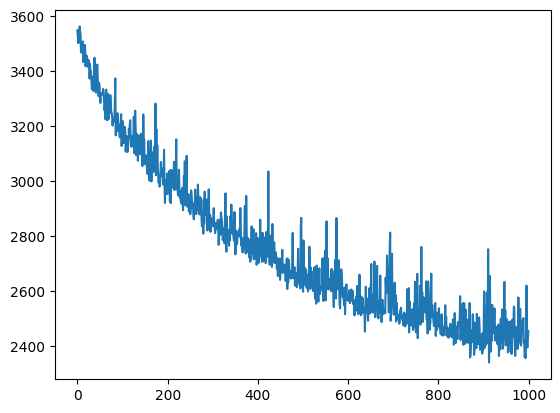

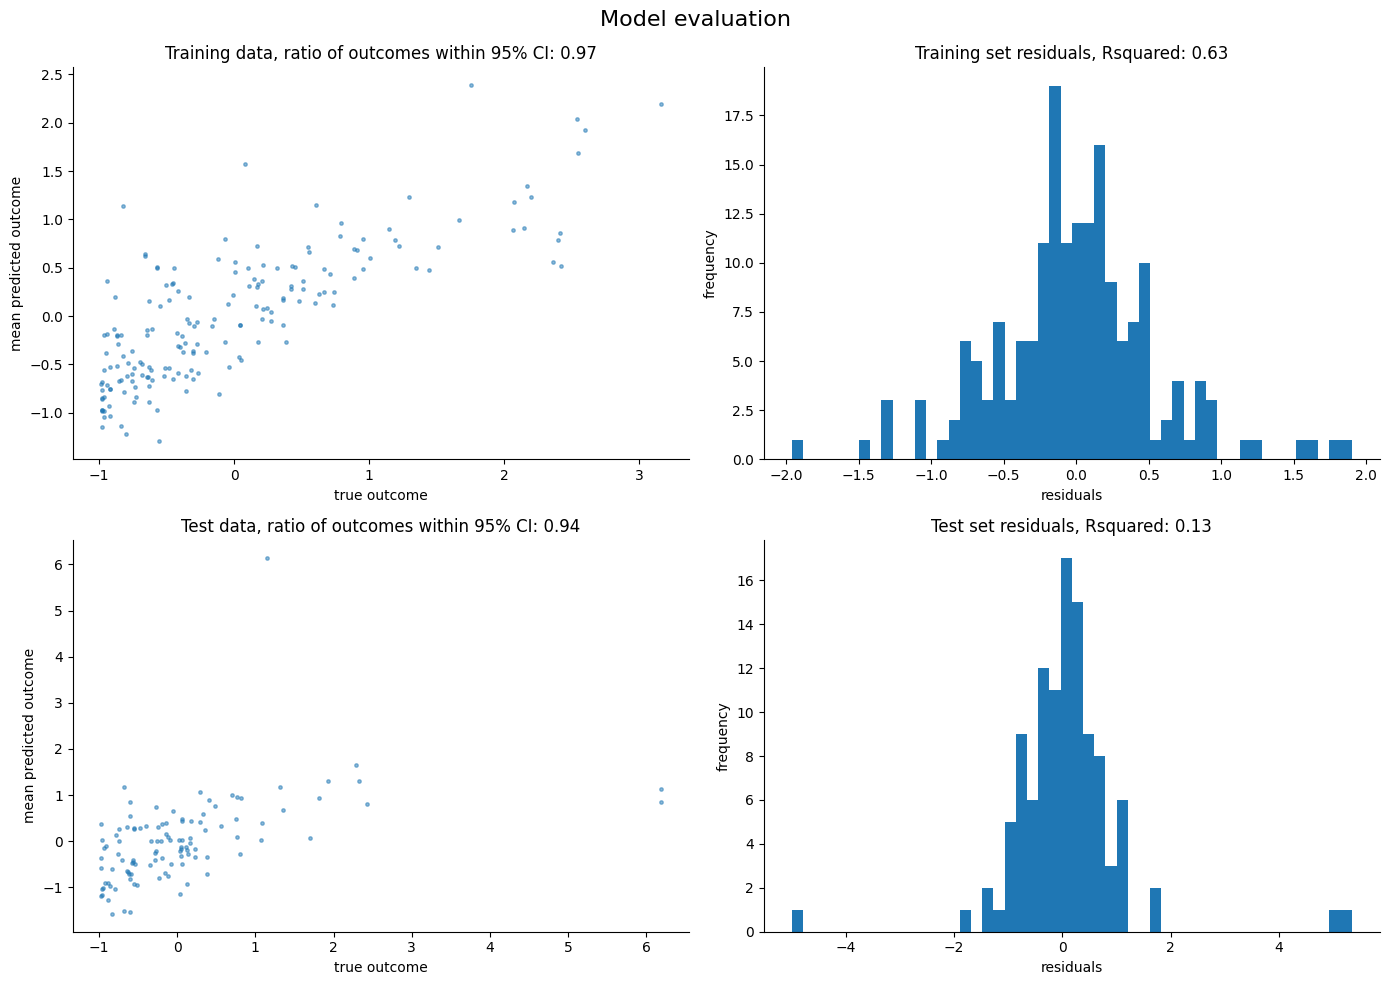

{'mae_train': 0.41404664516448975,
 'mae_test': 0.6223188638687134,
 'rsquared_train': tensor(0.6254),
 'rsquared_test': tensor(0.1289),
 'coverage_train': 0.9723756909370422,
 'coverage_test': 0.9363636374473572}

In [9]:
train_loader, test_loader, categorical_levels = prep_data_for_test(train_size=0.6)

kwargs = {  
    "categorical": ["year", "month", "zone_id", "neighborhood_id", "ward_id", 
                    "past_reform"],
    "continuous": {'limit_con', 'parcel_area'},
    "outcome": "housing_units",
}

test_performance(
    units_model, kwargs, train_loader, test_loader, categorical_levels, n_steps = 1000, plot=True, is_class = False
)

[iteration 0001] loss: 5758.3604
[iteration 0050] loss: 5197.3613
[iteration 0100] loss: 4906.5815
[iteration 0150] loss: 4662.7471
[iteration 0200] loss: 4409.5991
[iteration 0250] loss: 4440.8916
[iteration 0300] loss: 4215.9683
[iteration 0350] loss: 4132.6377
[iteration 0400] loss: 4311.8911
[iteration 0450] loss: 4041.1912
[iteration 0500] loss: 4039.6260
[iteration 0550] loss: 3865.6941
[iteration 0600] loss: 3867.9131
[iteration 0650] loss: 3865.3872
[iteration 0700] loss: 3939.8738
[iteration 0750] loss: 3845.7192
[iteration 0800] loss: 3807.7688
[iteration 0850] loss: 3773.8796
[iteration 0900] loss: 3737.3220
[iteration 0950] loss: 3859.9285
[iteration 1000] loss: 3839.4609


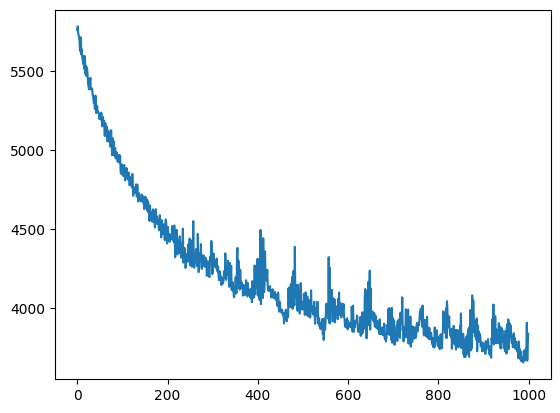

In [10]:
pyro.clear_param_store()
guide = run_svi_inference(units_model, n_steps=1000, lr = 0.02,
                          vi_family=AutoDiagonalNormal,
                            **subset)

In [11]:
predictive = PredictiveModel(units_model, guide)

subset_no_outcome = copy.deepcopy(subset)  

observed_housing_units = subset['outcome'].detach()
subset_no_outcome['outcome'] = None

# print(subset['continuous']['limit_con'])

with MultiWorldCounterfactual() as mwc:
    with do(actions = {'limit_con': torch.tensor(1.)}):
            with pyro.plate("samples", size = 300, dim = -6):
                with pyro.poutine.trace() as tr:
                    hu = predictive(**subset_no_outcome) 

print(hu.shape)

print(tr.trace.nodes['housing_units']['value'].shape)


torch.Size([300, 300, 2, 1, 1, 1, 302])
torch.Size([300, 300, 2, 1, 1, 1, 302])


In [12]:
predictive = Predictive(model = units_model, guide=guide, num_samples=500)

with MultiWorldCounterfactual() as mwc:
    with do(actions = {'limit_con': torch.tensor(1.)}):
        samples =  predictive(**subset_no_outcome) 

print(
samples['limit_con'].shape
)


print(samples['housing_units'].shape)


torch.Size([500, 2, 1, 1, 1, 302])
torch.Size([500, 2, 1, 1, 1, 302])


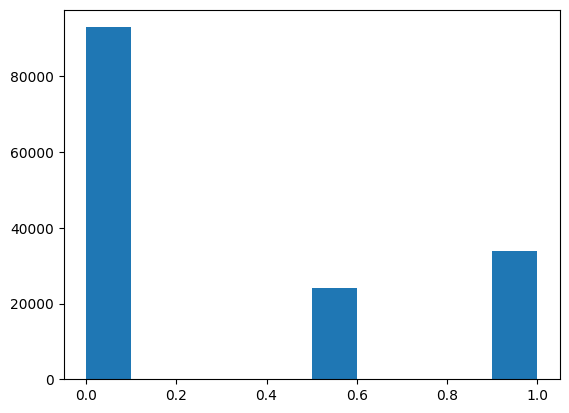

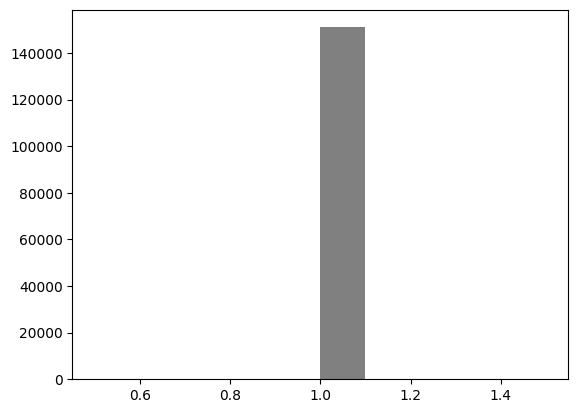

In [13]:
with mwc:

    factual_limit_con = gather(samples['limit_con'],
                IndexSet(**{"limit_con": {0}}),event_dims=0)
    counterfactual_limit_con = gather(samples['limit_con'],
                IndexSet(**{"limit_con": {1}}), event_dims=0
    )

    factual_housing_units = gather(samples['housing_units'], 
                IndexSet(**{"limit_con": {0}}),event_dims=0)
    
    counterfactual_housing_units = gather(samples['housing_units'],
                IndexSet(**{"limit_con": {1}}),event_dims=0)


plt.hist(factual_limit_con.flatten())
plt.show()
plt.hist(counterfactual_limit_con.flatten(), color = "grey")
plt.show()


In [14]:
factual_housing_units_means = factual_housing_units.mean(axis = 0).flatten().detach()
factual_housing_units_low = factual_housing_units.quantile(0.05, axis = 0).flatten().detach()
factual_housing_units_high = factual_housing_units.quantile(0.95, axis = 0).flatten().detach()

counterfactual_housing_units_means = counterfactual_housing_units.mean(axis = 0).flatten().detach()
counterfactual_housing_units_low = counterfactual_housing_units.quantile(0.05, axis = 0).flatten().detach()
counterfactual_housing_units_high = counterfactual_housing_units.quantile(0.95, axis = 0).flatten().detach()

# plt.hist(counterfactual_housing_units_means - factual_housing_units_means, bins = 20)
# plt.show()


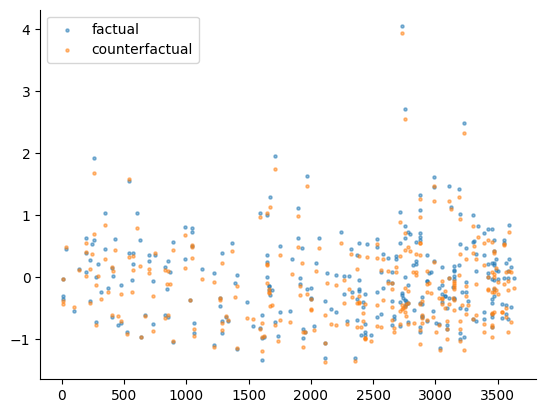

In [15]:
plt.scatter(x= data['categorical']['day'].numpy(), y = factual_housing_units_means, s= 5, alpha = 0.5, label = "factual")
plt.scatter( x = data['categorical']['day'].numpy(), y = counterfactual_housing_units_means, s = 5, alpha = 0.5, label = "counterfactual")
plt.legend()
sns.despine()
plt.show()



(302,)


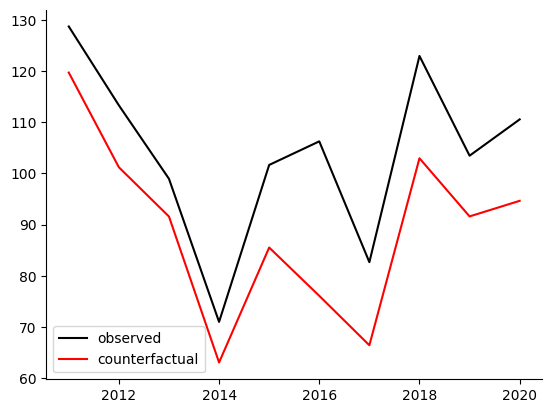

In [16]:
year = (subset['categorical']['year'] + 2011).numpy()
day = data['categorical']['day'].numpy()
print(day.shape)

def destandardize_housing_units(column):
    mean = zoning_dataset_read.standardization_dictionary['housing_units']['mean']
    std = zoning_dataset_read.standardization_dictionary['housing_units']['std']

    return (column * std + mean).round()

observed_df = pd.DataFrame({
    'year': year,
    'day': day,
    'observed_housing_units': destandardize_housing_units(observed_housing_units),
    })


observed_df_by_year = observed_df.groupby('year').mean().reset_index()

counterfactual_df = pd.DataFrame({
    'year': year,
    'day': day,
    'counterfactual_housing_units_mean': destandardize_housing_units(counterfactual_housing_units_means),
    'counterfactual_housing_units_low': destandardize_housing_units(counterfactual_housing_units_low),
    'counterfactual_housing_units_high': destandardize_housing_units(counterfactual_housing_units_high),
    })


counterfactual_df_by_year = counterfactual_df.groupby('year').mean().reset_index()

plt.plot(observed_df_by_year['year'], observed_df_by_year['observed_housing_units'], color = "black", label = "observed")
plt.plot(observed_df_by_year['year'], counterfactual_df_by_year['counterfactual_housing_units_mean'], color = "red", label = "counterfactual")
plt.legend()
sns.despine()
plt.show()
